# Variational Autoencoders using Fashion MNIST


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Layer , Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape , BatchNormalization , Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


In [5]:
x_train.shape

(60000, 28, 28, 1)

VAE have extra sampling layer in the latent space

In [6]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

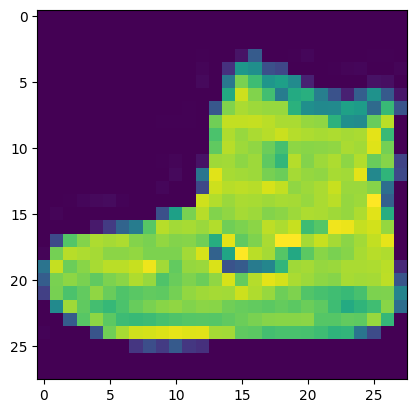

In [16]:
plt.imshow(x_train[0].reshape(28,28))

In [52]:
def encoder(latent_dims):
  inputs = Input(shape=(28 , 28 , 1))
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(32 , activation='relu')(x)
  x = Dense(16 , activation='relu')(x)
  z_mean = Dense(latent_dims , name = 'z_mean')(x)
  z_log_var = Dense(latent_dims , name = 'z_log_var')(x)
  z = Sampling()([z_mean , z_log_var])
  model =  Model(inputs , [z_mean , z_log_var , z] , name = 'encoder')
  return model

In [34]:
#
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 64)     │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 14, 14, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 14, 14, 64)     │            256 │ max_pooling2d_8[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 32)     │         18,464 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 7, 7, 32)       │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 7, 7, 32)       │            128 │ max_pooling2d_9[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 1568)           │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 32)             │         50,208 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 16)             │            528 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,292 (274.58 KB)

 Trainable params: 70,100 (273.83 KB)

 Non-trainable params: 192 (768.00 B)

In [53]:
def decoder(latent_dims):
  inputs = Input(shape=(latent_dims,))
  x = Dense(7 * 7 * 64, activation='relu')(inputs)
  x = Reshape((7, 7, 64))(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  model = Model(inputs, outputs, name='decoder')
  return model

In [38]:
decoder = decoder(2)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,585 (185.88 KB)

 Trainable params: 47,265 (184.63 KB)

 Non-trainable params: 320 (1.25 KB)

In [13]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def build_encoder(self):
        inputs = Input(shape=(28, 28, 1))
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Flatten()(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        z_mean = Dense(self.latent_dims, name='z_mean')(x)
        z_log_var = Dense(self.latent_dims, name='z_log_var')(x)
        z = Sampling()([z_mean, z_log_var])
        model = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        return model

    def build_decoder(self):
        inputs = Input(shape=(self.latent_dims,))
        x = Dense(7 * 7 * 64, activation='relu')(inputs)
        x = Reshape((7, 7, 64))(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        model = Model(inputs, outputs, name='decoder')
        return model

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [14]:
latent_dim = 2

# encoder1 = encoder(latent_dim)
# decoder1 = encoder(latent_dim)
vae = VAE(latent_dim)

In [17]:
vae.compile(optimizer=Adam() , loss = 'mse')

In [18]:
istory = vae.fit(x_train,
                 x_train,  # Use x_train as both input and target
                 epochs=30,
                 batch_size=128,
                 validation_data=(x_test, x_test))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - kl_loss: 3.7796 - loss: 272.8358 - reconstruction_loss: 269.0562 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - kl_loss: 3.6668 - loss: 266.9823 - reconstruction_loss: 263.3156 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 3.6430 - loss: 263.8252 - reconstruction_loss: 260.1822 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl_loss: 3.6339 - loss: 262.5212 - reconstruction_loss: 258.8874 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - kl_loss: 3.6193 - loss: 261.7794 - reconstruction_loss: 258.1602 - val_kl_loss: 0.0000e+00

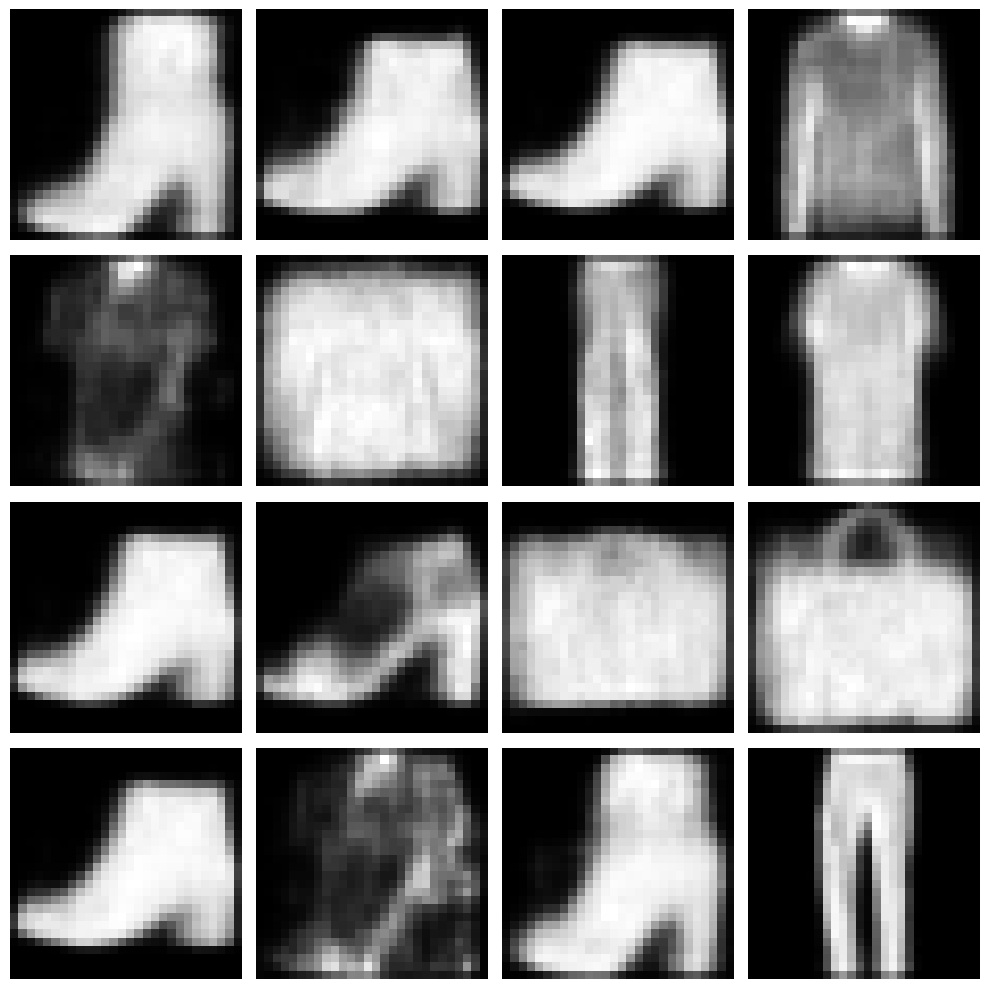

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random points in the latent space
n = 16  # 4x4 grid
latent_points = np.random.normal(0, 1, (n, latent_dim))

# Generate images from these points
generated_images = vae.decoder(latent_points)

# Create a figure to display the images
plt.figure(figsize=(10, 10))

for i in range(n):
    # Plot each image in the grid
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
vae.save('VAE.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


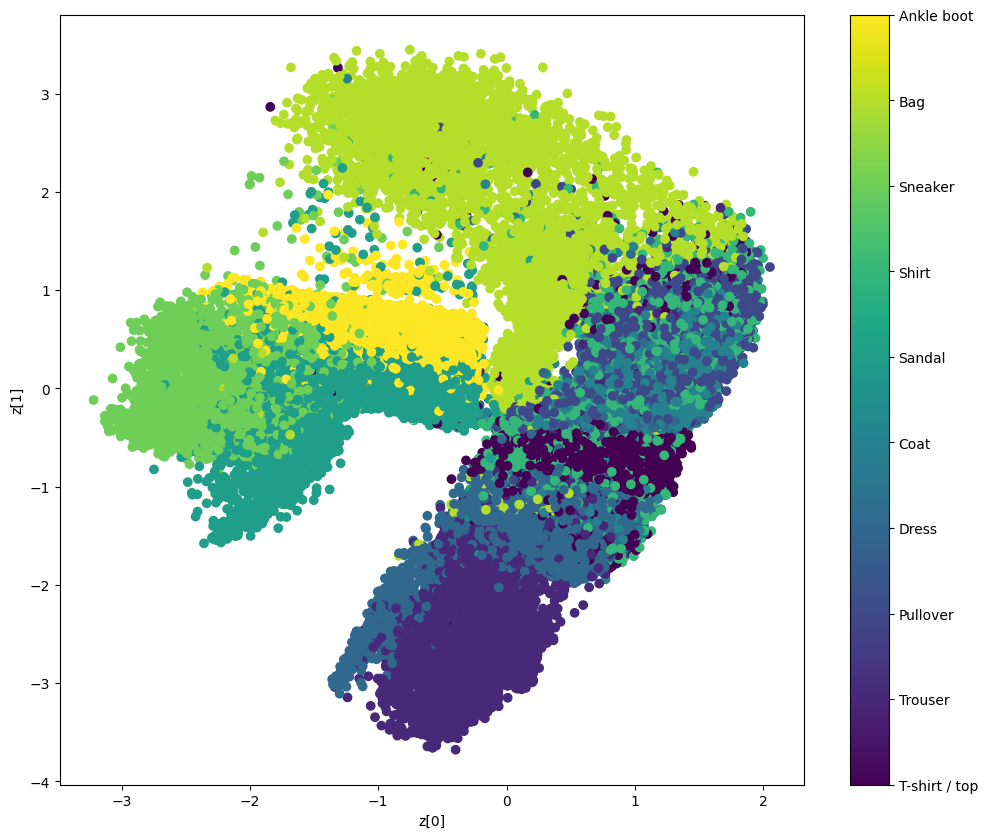

In [26]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


labels = {0    :"T-shirt / top",
1:    "Trouser",
2:    "Pullover",
3:    "Dress",
4:    "Coat",
5:    "Sandal",
6:    "Shirt",
7:    "Sneaker",
8:    "Bag",
9:    "Ankle boot"}

(X_train, y_train), _ = fashion_mnist.load_data()
X_train = np.expand_dims(X_train, -1).astype("float32") / 255
plot_label_clusters(vae.encoder, vae.decoder
                    , X_train, y_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

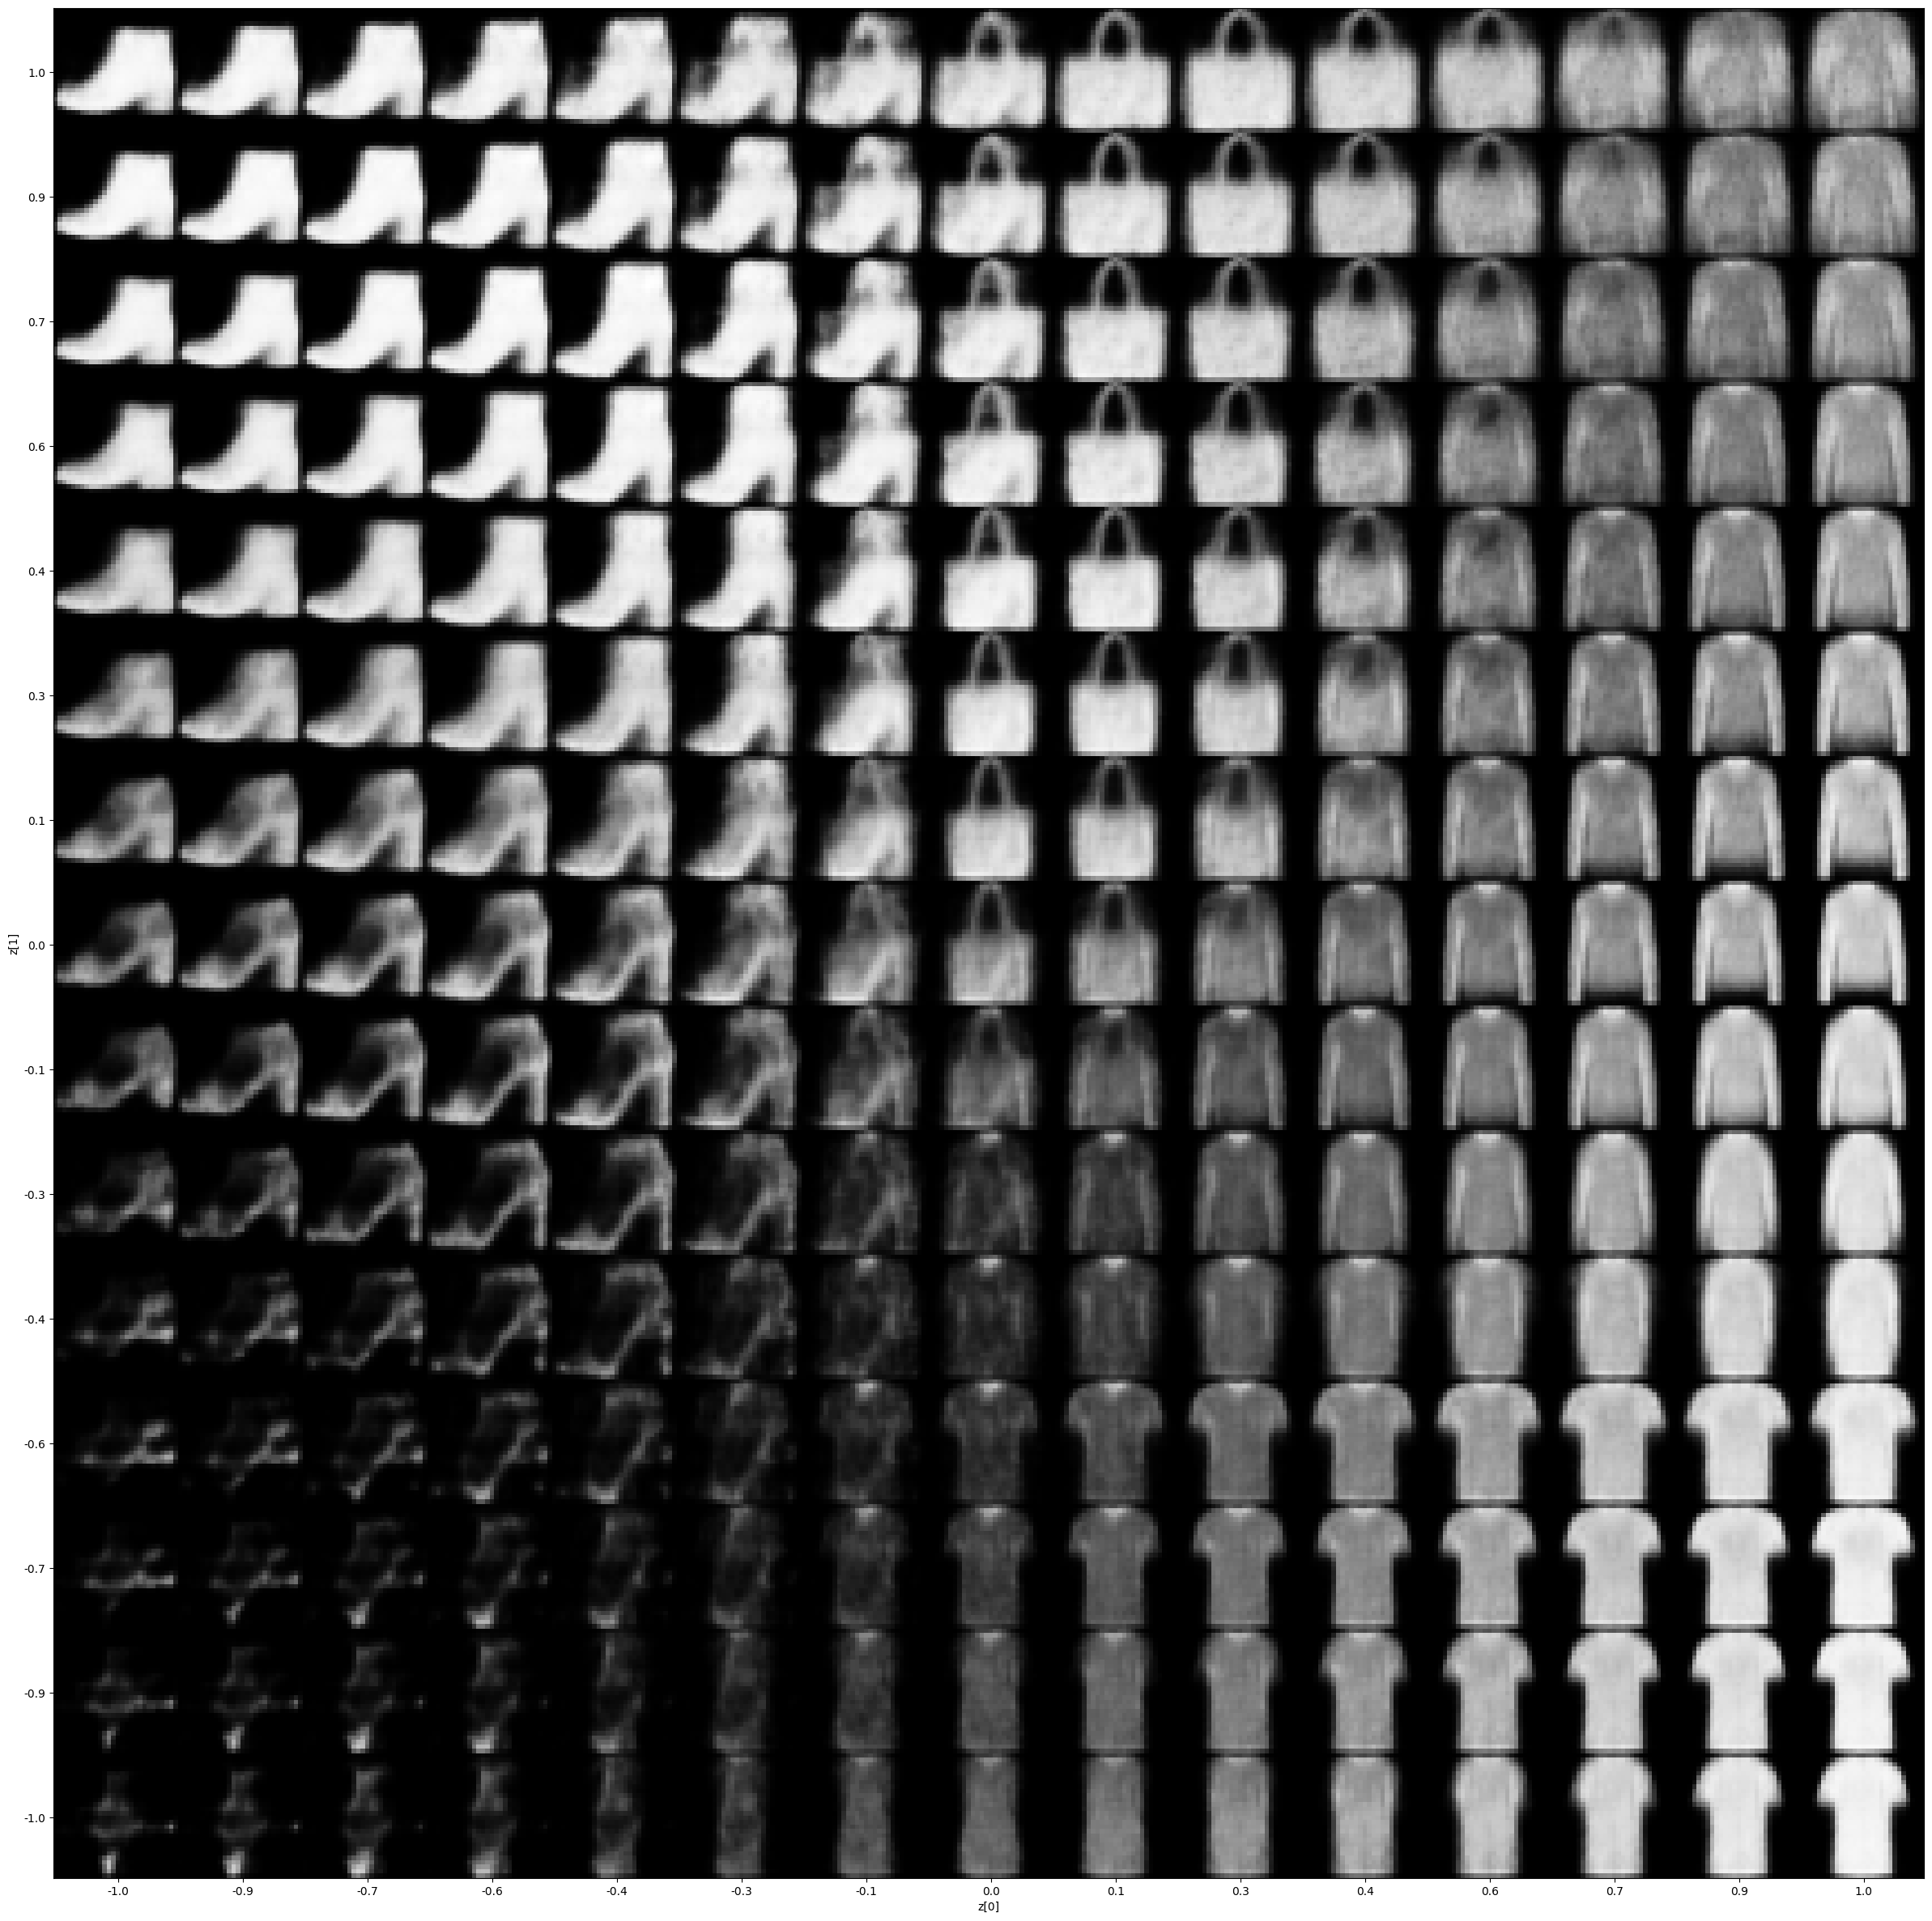

In [32]:
# prompt: plot the latent space representation

import matplotlib.pyplot as plt

def plot_latent_space(vae, n=15, figsize=30):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)
